# Mass Transports

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [13]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
# import seaborn as sns

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [43]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [2]:
from joblib import Memory
memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/g/data1/v45/cosima-cookbook/'", use "location=None" instead.
  from ipykernel import kernelapp as app


In [3]:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 46500:127.0.0.1:46500 vdi-n10.nci.org.au -l aek156


Client Scheduler: tcp://127.0.0.1:36709 Dashboard: http://127.0.0.1:46500/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [14]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional
straits = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.6+360, -243.9+360, -8.6, -8.6]), # BUG: on land? zero transport.
            ('Ombai Strait',  [-235.0+360, -235.0+360, -9.2, -8.1]),
            ('Timor Strait',  [-235.9+360, -235.9+360, -11.9, -9.9]),
            ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 65.8, 65.8])
            ])

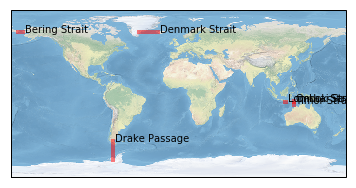

In [5]:
# TODO: plot straits on actual model bathymetry 


import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for strait, (xmin, xmax, ymin, ymax) in straits.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=strait,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [6]:
@memory.cache
def calc_transport(expt, strait, n=None):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    print('Calculating {} {} transport'.format(expt, strait))
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if xmin == xmax:                
        tx_trans = cc.get_nc_variable(expt, 
                                'ocean.nc', 
                                'tx_trans',
                                 chunks={'st_ocean':None},
                                 n=n)
        
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('st_ocean').sum('yt_ocean')

    elif ymin == ymax:
        ty_trans = cc.get_nc_variable(expt, 
                                      'ocean.nc', 
                                      'ty_trans',
                                      chunks={'st_ocean':None},
                                      n=n)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('st_ocean').sum('xt_ocean')
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and how="mean", instead consider using .resample(time="A").mean('time') 
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


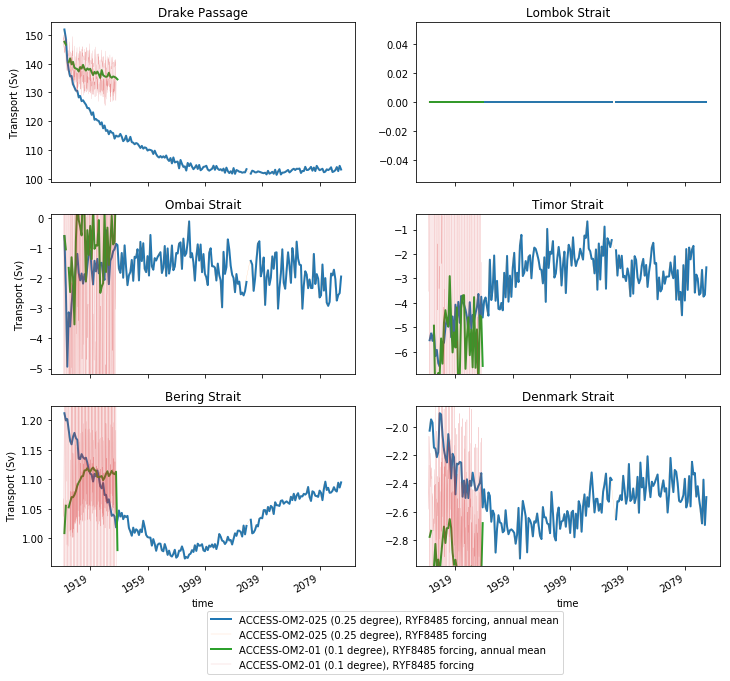

In [51]:
ncols = 2
nrows = math.ceil(len(straits)/ncols)
tstart = 1e10
tend = -1e10
# transports = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
plt.figure(figsize=(12,10))
for ekey in exptdata.exptdict.keys():
    if ekey != '1deg': # TODO: fix this case
        expt = exptdata.exptdict[ekey]['expt']
        desc = exptdata.exptdict[ekey]['desc']
        for i, strait in enumerate(straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
            transport = calc_transport(expt, strait)/1e6/1036
            transport_mean = transport.resample('A', 'time')
#             tstart = min(tstart, transport['time'].data[0])  # first time in model data
#             tend = max(tend, transport['time'].data[-1])  # final time in model data

            plt.subplot(nrows, ncols, i+1)
            transport_mean.plot(label=desc+', annual mean', linewidth=2)
            transport.plot(label=desc, linewidth=0.2, alpha=0.5)
            plt.title(strait)
            plt.ylabel('')

for k in range(1,i+2,2):
    plt.subplot(nrows, ncols, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,i,1):
    plt.subplot(nrows, ncols, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

# for k in range(1,i+2,1):
#     plt.subplot(nrows, ncols, k)
#     plt.gca().xlim([tstart, tend])

plt.subplot(nrows, ncols, i+1)
plt.legend(bbox_to_anchor=(-0.1,-0.25), loc='upper center')

savefigure('strait_transports')